<a href="https://colab.research.google.com/github/rodrigoviannini/Machine-Learning/blob/main/Aula_11_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 11 - Naive Bayes

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Naive Bayes
- 3) A matemática do Naive Bayes
- 4) Outras versões do Naive Bayes

In [ ]:
import numpy as np
import pandas as pd

_____
_____
_____

## 1) Introdução

Em estatística, fomos apresentados ao Teorema de Bayes:

$P(A|B) = \frac{P(B | A)P(A)}{P(B)}$

O teorema de Bayes nos permite descobrir a probabilidade condicional $P(A|B)$, que é chamada de **posterior**, com base na probabilidade condicional inversa, $P(B|A)$ (a chamada **likelihood**), e a probabilidade $P(A)$, a **priori**.

A ideia é que nós **atualizamos as nossas crenças sobre $A$**, conforme novas informações sobre $B$ são agregadas!

Vimos como o teorema de Bayes é bem útil para modelar experimentos estatísticos, de caracter probabilístico. A esta altura, é justo que nos perguntemos: seria o teorema de Bayes útil em modelagem? A resposta é: sim, através do método **Naive Bayes**!

_____
_____
_____

## 2) Naive Bayes

O Naive Bayes é um dos métodos mais simples e intuitivos para classificação, embora seja cheio de sutilezas importantes.

Por este motivo, vamos primeiramente construir a ideia do método, aplicá-lo, e só depois nos preocuparemos com seus detalhes mais matemáticos!

Uma das principais e mais bem-sucedidas aplicações deste método é no **filtro de spam**: dado um e-mail, como determinar se ele é spam ou não?

<img src=https://repository-images.githubusercontent.com/218616244/c4183680-fb99-11e9-8191-d7c5dfb6a11e width=500>

Pra resolvermos este problema (e introduzir o Naive Bayes), vamos considerar o seguinte toy dataset:

In [ ]:
train_spam = ['digite sua senha', 'digite sua senha aqui', 'cupom de desconto aqui',
              'envie senha e ganhe cupom de desconto', 'clique aqui ganhou desconto',
              'cupom de desconto e senha', 'desconto de senha',
              'sua senha aqui', 'você ganhou clique aqui']

train_ham = ['segue relatório', 'segue o orçamento', 'relatório em anexo',
             'pauta da reunião em anexo', 'relatório hoje', 'relatório de orçamento',
             'relatório em anexo', 'pauta do relatório', 'segue pauta da reunião']

df_train = pd.DataFrame([["spam", x] for x in train_spam] + [["ham", x] for x in train_ham],
                        columns = ["y", "frases"])

df_train

,y,frases
0,spam,digite sua senha
1,spam,digite sua senha aqui
2,spam,cupom de desconto aqui
3,spam,envie senha e ganhe cupom de desconto
4,spam,clique aqui ganhou desconto
5,spam,cupom de desconto e senha
6,spam,desconto de senha
7,spam,sua senha aqui
8,spam,você ganhou clique aqui
9,ham,segue relatório


In [ ]:
test_spam = ['digite aqui sua senha', 'cupom de desconto em anexo']

test_ham = ['cadê o relatório da pauta da reunião', 'envio ainda hoje em anexo']

df_test = pd.DataFrame([["spam", x] for x in test_spam] + [["ham", x] for x in test_ham],
                       columns = ["y", "frases"])

df_test

,y,frases
0,spam,digite aqui sua senha
1,spam,cupom de desconto em anexo
2,ham,cadê o relatório da pauta da reunião
3,ham,envio ainda hoje em anexo


O nosso target é binário e representa se as mensagens são `spam` ou não-spam (que são comumente chamadas de `ham`). Nosso objetivo é construir um classificados que seja capaz de **determinar se uma mensagem é spam ou ham, com base únicamente no texto da mensagem**.

O tipo de dados que estamos trabalhando é bem particular: temos **dados não estruturados**, pois (apesar de termos artificialmente construído um dataframe), os dados originais não vieram na forma tabular **com número fixo de features**. Aliás, uma pergunta justíssima é: **quais são as features?** Estas e outras perguntas serão respondidas em detalhes no **módulo de dados não estruturados!**

Aqui, não vamos nos preocupar com estes detalhes - seguiremos com uma abordagem (baseada no teorema de Bayes) que tratará estes detalhes de maneira mais indireta.


Vamos começar a construir o classificador!

______

Uma vez que queremos classificar uma mensagem como spam ou ham, estamos preocupados com a **separabilidade do target**.

Inspirados pela regressão logística, uma boa abordagem pra fazer isso é nos basear na **probabilidade de uma mensagem pertencer a uma ou outra classe**, justo?

O legal e que, antes de fazer qualquer coisa, já temos uma estimativa pra essa probabilidade: basta olhar para a frequência de cada classe nos dados! (semelhante à proporção anterior à primeira quebra de uma árvore):

In [ ]:
P = df_train["y"].value_counts(normalize=True)

P

spam    0.5
ham     0.5
Name: y, dtype: float64

Essas são as **probabilidades a priori**! Nada muito informativo (temos a situação de maior entropia/impureza!), mas essa é uma informação relevante, então vamos anotar:

$P(y = \text{spam}) = 0.5 $

$ P(y = \text{ham}) = 0.5 $

In [ ]:
P_spam, P_ham = P["spam"], P["ham"]

P_spam, P_ham

(0.5, 0.5)

Uma vez que temos isso, como podemos proceder pra **ganhar mais informação quanto à separabilidade do target**?

A ideia é a seguinte: vamos **olhar pro target**, e nos perguntar: 

> **Quais palavras aparecem mais frequentemente em e-mails que são spam/ham?**. 

Parece justo, né?

A ideia vai ser associar um grau de "spamicity" (e "hamicity") à cada palavra!

Vamos ver em ação...

In [ ]:
# isso dá a informação de y="spam"

train_spam

['digite sua senha',
 'digite sua senha aqui',
 'cupom de desconto aqui',
 'envie senha e ganhe cupom de desconto',
 'clique aqui ganhou desconto',
 'cupom de desconto e senha',
 'desconto de senha',
 'sua senha aqui',
 'você ganhou clique aqui']

In [ ]:
# dicionário que conta quantas aparições de cada palavra há no conjunto de palavras spam
# estrutura: {"palavra" : frequencia nas frases spam}

palavras_spam = {}

for frase in train_spam:
    
    for palavra in frase.split():
        
        if palavra not in palavras_spam:
            
            palavras_spam[palavra] = 1
            
        else:
            
            palavras_spam[palavra] += 1
            
palavras_spam            

{'digite': 2,
 'sua': 3,
 'senha': 6,
 'aqui': 5,
 'cupom': 3,
 'de': 4,
 'desconto': 5,
 'envie': 1,
 'e': 2,
 'ganhe': 1,
 'clique': 2,
 'ganhou': 2,
 'você': 1}

In [ ]:
train_ham

['segue relatório',
 'segue o orçamento',
 'relatório em anexo',
 'pauta da reunião em anexo',
 'relatório hoje',
 'relatório de orçamento',
 'relatório em anexo',
 'pauta do relatório',
 'segue pauta da reunião']

In [ ]:
# dicionário que conta quantas aparições de cada palavra há no conjunto de palavras ham
# estrutura: {"palavra" : frequencia nas frases ham}

palavras_ham = {}

for frase in train_ham:
    
    for palavra in frase.split():
        
        if palavra not in palavras_ham:
            
            palavras_ham[palavra] = 1
            
        else:
            palavras_ham[palavra] += 1
            
palavras_ham   

{'segue': 3,
 'relatório': 6,
 'o': 1,
 'orçamento': 2,
 'em': 3,
 'anexo': 3,
 'pauta': 3,
 'da': 2,
 'reunião': 2,
 'hoje': 1,
 'de': 1,
 'do': 1}

Agora vamos fazer algo que pode não parecer muito natural, mas que será de grande importância operacional: vamos adicionar aos dicionários até mesmo as palavras que não aparecem no respectivo conjunto de palavras, todas com contagem zero. Isso é importante pra "homogeinizar" os dados, marcando presença de todas as palavras que aparecem nos dados de treino como um todo nos dicionários de ambas as classes -- mas, claro, deixando claro a ausência delas com a contagem nula. Adiante, vamos entender porque isso é importante!

In [ ]:
for palavra in palavras_spam:
    
    if palavra not in palavras_ham:
        
        palavras_ham[palavra] = 0
        
############################################

for palavra in palavras_ham:
    
    if palavra not in palavras_spam:
        
        palavras_spam[palavra] = 0

In [ ]:
palavras_spam

{'digite': 2,
 'sua': 3,
 'senha': 6,
 'aqui': 5,
 'cupom': 3,
 'de': 4,
 'desconto': 5,
 'envie': 1,
 'e': 2,
 'ganhe': 1,
 'clique': 2,
 'ganhou': 2,
 'você': 1,
 'segue': 0,
 'relatório': 0,
 'o': 0,
 'orçamento': 0,
 'em': 0,
 'anexo': 0,
 'pauta': 0,
 'da': 0,
 'reunião': 0,
 'hoje': 0,
 'do': 0}

In [ ]:
palavras_ham

{'segue': 3,
 'relatório': 6,
 'o': 1,
 'orçamento': 2,
 'em': 3,
 'anexo': 3,
 'pauta': 3,
 'da': 2,
 'reunião': 2,
 'hoje': 1,
 'de': 1,
 'do': 1,
 'digite': 0,
 'sua': 0,
 'senha': 0,
 'aqui': 0,
 'cupom': 0,
 'desconto': 0,
 'envie': 0,
 'e': 0,
 'ganhe': 0,
 'clique': 0,
 'ganhou': 0,
 'você': 0}

In [ ]:
# check - deve vir vazia
[x for x in palavras_ham.keys() if x not in palavras_spam.keys()]

[]

In [ ]:
# check - deve vir vazia
[x for x in palavras_spam.keys() if x not in palavras_ham.keys()]

[]

In [ ]:
# número de palavras no vocabulário
n_vocab = len(palavras_ham)

n_vocab

24

In [ ]:
len(palavras_spam)

24

Os dicionários acima indicam a **frequência absoluta** de cada palavra dentro de cada contexto (spam vs ham). Pra tornar nossa abordagem mais robusta, seria interessante se tivéssemos as **frequências relativas**, que possam ser entendidas como **probabilidades**! 

Note que o que estamos querendo calcular é uma **probabilidade condicional**. Por exemplo:

> qual é a probabilidade de encontrar a palavra "senha" em um e-mail **dado que** o e-mail foi marcado como "spam"? <br><br> 
$$P(x_i = \text{"senha"} \mid y = \text{"spam"})$$

Este cálculo é muito simples: basta calcular a **frequência relativa** da palavra "senha" dentro dos e-mails de spam:

$$ P(x_i = \text{"senha"} \mid y = \text{"spam"}) = \frac{\text{# "senha"}}{\text{# total palavras em "spam"}} $$

Vamos ver no código:

In [ ]:
df_palavras_spam = pd.DataFrame([[k, v] for k, v in palavras_spam.items()],
                                columns = ["palavras", "contagem"])

df_palavras_spam["prob"] = df_palavras_spam["contagem"]/df_palavras_spam["contagem"].sum()

df_palavras_spam = df_palavras_spam.sort_values("prob", ascending=False)

df_palavras_spam

,palavras,contagem,prob
2,senha,6,0.162162
3,aqui,5,0.135135
6,desconto,5,0.135135
5,de,4,0.108108
4,cupom,3,0.081081
1,sua,3,0.081081
0,digite,2,0.054054
10,clique,2,0.054054
8,e,2,0.054054
11,ganhou,2,0.054054


In [ ]:
df_palavras_ham = pd.DataFrame([[k, v] for k, v in palavras_ham.items()],
                                columns = ["palavras", "contagem"])

df_palavras_ham["prob"] = df_palavras_ham["contagem"]/df_palavras_ham["contagem"].sum()

df_palavras_ham = df_palavras_ham.sort_values("prob", ascending=False)

df_palavras_ham

,palavras,contagem,prob
1,relatório,6,0.214286
0,segue,3,0.107143
6,pauta,3,0.107143
4,em,3,0.107143
5,anexo,3,0.107143
7,da,2,0.071429
8,reunião,2,0.071429
3,orçamento,2,0.071429
9,hoje,1,0.035714
10,de,1,0.035714


### MUITO IMPORTANTE:

> Note que com esses dataframes temos os **graus de "spamicity" e "hamicity"**, respectivamente, **para cada palavra na base de treino**, expresso através justamente das probabilidades $P(x_i \mid y)$. Esse é um dos pontos mais importantes do Naive Bayes!!

Ou seja, é possível ver que as palavras "senha" e "aqui" têm o maior grau de spamicity; enquanto "relatório" é a palavra com maior grau de hamicity. Faz sentido??

Agora, vamos fazer mais uma coisa que parece não natural a princípio, mas que vai ser operacionalmente bastante importante!

Acima, nós incluímos artificialmente palavras que não aparecem em spam também ao dataframe de spam, e vice-versa, para garantir que ambos os dataframes contanham exatamente as mesmas palavras (isso vai ser impotante operacionalmente, como veremos abaixo). 

No entanto, da forma que fizemos, todas etas palavras têm contagem nula, e, portanto, probabilidade (e spamicity e hamicity) nula. Operacionalmente isso é um problema (já vamos entender o porquê). Pra evitar que esse problema se manifeste, vamos fazer o seguinte: **adicionar +1 na contagem de todas as palavras** (na verdade, podemos adicionar qualquer valor, comumente denotado $\alpha > 0$, e chamado de **parâmetro de suavização (smoothing)**. 

Fazendo isso, todas as palavras em cada classe terão uma probabilidade associada, de maneira homogênea -- até mesmo as palavras que não fazem parte das frases daquela classe! 

Mas, naturalmente, a probabilidade destas palavras será baixíssima (as palavras que aparecem apenas em "spam" tem uma hamicity muito baixa (como "senha", por exemplo); e as que aparecem apenas em "ham" tem uma spamicity muito baixa (como "relatório", por exemplo). 

Então, apesar da spamicity e hamicity ser afetada pra todas as palavras, teremos o aspecto **relativo** mantido, e isso que importa, como veremos!

In [ ]:
alpha = 1

# adicionando 1 à contagem de TODAS as palavras de spam
df_palavras_spam["contagem"] = df_palavras_spam["contagem"] + alpha

df_palavras_spam["prob"] = df_palavras_spam["contagem"]/df_palavras_spam["contagem"].sum()

## outra possibilidade de suavização
# df_palavras_spam["prob"] = df_palavras_spam["contagem"]/(df_palavras_spam["contagem"].sum() + alpha*n_vocab)

df_palavras_spam = df_palavras_spam.sort_values("prob", ascending=False)

#################################################################################
#################################################################################

# adicionando 1 à contagem de TODAS as palavras de ham
df_palavras_ham["contagem"] = df_palavras_ham["contagem"] + alpha

df_palavras_ham["prob"] = df_palavras_ham["contagem"]/df_palavras_ham["contagem"].sum()

## outra possibilidade de suavização
# df_palavras_ham["prob"] = df_palavras_ham["contagem"]/(df_palavras_ham["contagem"].sum() + alpha*n_vocab)

df_palavras_ham = df_palavras_ham.sort_values("prob", ascending=False)

In [ ]:
df_palavras_spam

,palavras,contagem,prob
2,senha,7,0.114754
6,desconto,6,0.098361
3,aqui,6,0.098361
5,de,5,0.081967
4,cupom,4,0.065574
1,sua,4,0.065574
0,digite,3,0.049180
10,clique,3,0.049180
8,e,3,0.049180
11,ganhou,3,0.049180


In [ ]:
df_palavras_ham

,palavras,contagem,prob
1,relatório,7,0.134615
6,pauta,4,0.076923
4,em,4,0.076923
5,anexo,4,0.076923
0,segue,4,0.076923
7,da,3,0.057692
8,reunião,3,0.057692
3,orçamento,3,0.057692
11,do,2,0.038462
2,o,2,0.038462


Lembrando o teorema de Bayes:

$P(A|B) = \frac{P(B | A)P(A)}{P(B)}$

Vamos tomar:

$A= y$; $B = \vec{x}$

Ou seja,

$P(y| \vec{x}) = \frac{P( \vec{x} | y)P(y)}{P( \vec{x})}$

$P(y|\vec{x}) \propto P( \vec{x}| y)P(y)$

Agora temos todos os ingredientes que precisamos! Utilizando o teorema de Bayes (na próxima seção vamos entender melhor de onde veio isso), podemos **classificar frases de teste** olhando para **cada palavra como feature** para que possamos calcular qual é a **probabilidade que a frase seja ham ou spam**, usando a seguinte relação:

$$P(y \mid \vec{x}) \propto P(\vec{x} \mid y) P(y) \ , $$

sendo avaliada para ambas as classes possíveis para $y$:

$$P(y = \text{"spam"} \mid \vec{x} = \text{"texto do email"}) \propto P(\vec{x} = \text{"texto do email"} \mid y = \text{"spam"}) P(y = \text{"spam"})$$

E, analogamente,

$$P(y = \text{"ham"} \mid \vec{x} = \text{"texto do email"}) \propto P(\vec{x} = \text{"texto do email"} \mid y = \text{"ham"}) P(y = \text{"ham"})$$



Nas equações acima, a proporcionalidade já basta, pois no final a decisão a ser tomada é:

$$ \text{Se} \qquad P(y = \text{"spam"} \mid \vec{x} = \text{"texto do email"}) > P(y = \text{"ham"} \mid \vec{x} = \text{"texto do email"}) \qquad \text{então} \qquad \hat{y} = \text{"spam"}$$

E, caso contrário, 

$$ \text{Se} \qquad P(y = \text{"ham"} \mid \vec{x} = \text{"texto do email"}) > P(y = \text{"spam"} \mid \vec{x} = \text{"texto do email"}) \qquad \text{então} \qquad \hat{y} = \text{"ham"}$$

A esta altura, nós já temos os valores das **prioris** $P(y)$! 

O único elemento que tá faltando é $P(\vec{x} \mid y)$, que é a **likelihood**. No entanto, tudo o que fizemo acima foi justamente pra ter a likelihood, que é dada por:

$P(\vec{x} \mid y) = \prod_{i=1}^{n} P(x_i \mid y) $

Onde cada $x_i$ representa uma palavra que compõe a frase de teste -- e essas probabilidades são exatamente o que temos nos dataframes acima!

Agora sim, podemos calcular $P(y \mid \vec{x})$!

Vamos começar com a primeira frase de teste:

In [ ]:
frase = df_test.loc[0, "frases"]

frase

'digite aqui sua senha'

$P(\vec{x} = \text{'digite aqui sua senha'} \mid y = \text{"spam"}) = \prod_{i=1}^{n} P(x_i \mid y = \text{"spam"}) = $


$  P(x = \text{'digite'} \mid y = \text{"spam"})  P(x = \text{'aqui'}  \mid y = \text{"spam"})  P(x = \text{'sua'} \mid y = \text{"spam"})  P(x = \text{'senha'} \mid y = \text{"spam"}) $

In [ ]:
P_spam_dado_x = 1

for palavra in frase.split():
    
    if palavra in df_palavras_spam["palavras"].values:
        
        P_x_dado_spam = df_palavras_spam.loc[df_palavras_spam["palavras"] == palavra, "prob"].squeeze()
        
        print(palavra, P_x_dado_spam)
        
        P_spam_dado_x = P_spam_dado_x*P_x_dado_spam
        
# multiplicando pela priori, no fim
P_spam_dado_x = P_spam_dado_x*P_spam

print(f"\nP(y='spam' | x='{frase}') = {P_spam_dado_x}")

digite 0.04918032786885246
aqui 0.09836065573770492
sua 0.06557377049180328
senha 0.11475409836065574

P(y='spam' | x='digite aqui sua senha') = 1.820041122818036e-05


In [ ]:
P_ham_dado_x = 1

for palavra in frase.split():
    
    if palavra in df_palavras_ham["palavras"].values:
        
        P_x_dado_ham = df_palavras_ham.loc[df_palavras_ham["palavras"] == palavra, "prob"].squeeze()
        
        print(palavra, P_x_dado_ham)
        
        P_ham_dado_x = P_ham_dado_x*P_x_dado_ham
        
# multiplicando pela priori, no fim
P_ham_dado_x = P_ham_dado_x*P_ham
        
print(f"\nP(y='ham' | x='{frase}') = {P_ham_dado_x}")

digite 0.019230769230769232
aqui 0.019230769230769232
sua 0.019230769230769232
senha 0.019230769230769232

P(y='ham' | x='digite aqui sua senha') = 6.838433528237808e-08


Note que no código acima há um `if` que testa se a palavra de teste faz parte do conjunto de palavras de treino. Isso é importante, porque se houver uma palavra desconhecida, não é possível avaliarmos qual é o seu grau de "spamicity" ou "hamicity".

Note, ainda, que fazemos esse check para ambos os casos, então não há nenhuma preferência em detrimento do spam ou do ham! (E por isso que foi importante que garantíssemos que todas as palavras estivessem contempladas em ambos os dataframes)

Uma vez que temos as probabilidades, basta tomar a decisão baseada na maior probabilidade:

In [ ]:
P_spam_dado_x/(P_spam_dado_x + P_ham_dado_x)

0.9962567682666971

In [ ]:
P_ham_dado_x/(P_spam_dado_x + P_ham_dado_x)

0.0037432317333029623

In [ ]:
if P_spam_dado_x > P_ham_dado_x:
    
    y_pred = "spam"
    
else:
    
    y_pred = "ham"

In [ ]:
y_pred

'spam'

In [ ]:
y_true = df_test.loc[0, "y"]

In [ ]:
y_true

'spam'

In [ ]:
print(f"Frase: '{frase}'\nTarget real: '{y_true}'\nTarget predito: '{y_pred}'")

Frase: 'digite aqui sua senha'
Target real: 'spam'
Target predito: 'spam'


Deu certo!!

Vamos agora colocar tudo num loop pra classificarmos todas as frases:

In [ ]:
lista_probs = []

for i in df_test.index:

    frase = df_test.loc[i, "frases"]
    y_true = df_test.loc[i, "y"]
    
    ###################################################################
    
    P_spam_dado_x = 1

    for palavra in frase.split():

        if palavra in df_palavras_spam["palavras"].values:

            P_x_dado_spam = df_palavras_spam.loc[df_palavras_spam["palavras"] == palavra, "prob"].squeeze()

            P_spam_dado_x = P_spam_dado_x*P_x_dado_spam

    P_spam_dado_x = P_spam_dado_x*P_spam

    print(f"P(y='spam' | x='{frase}') = {P_spam_dado_x}")
    
    ###################################################################

    P_ham_dado_x = 1

    for palavra in frase.split():

        if palavra in df_palavras_ham["palavras"].values:

            P_x_dado_ham = df_palavras_ham.loc[df_palavras_ham["palavras"] == palavra, "prob"].squeeze()

            P_ham_dado_x = P_ham_dado_x*P_x_dado_ham

    P_ham_dado_x = P_ham_dado_x*P_ham

    print(f"P(y='ham' | x='{frase}') = {P_ham_dado_x}")
    
    ###################################################################
    
    y_pred = "spam" if P_spam_dado_x > P_ham_dado_x else "ham"
    
    ###################################################################
    
    # normalizando as probabilidades, pra somar 1
    probs_aux = [P_ham_dado_x/(P_spam_dado_x + P_ham_dado_x), P_spam_dado_x/(P_spam_dado_x + P_ham_dado_x)]
    
    lista_probs.append(probs_aux)
    
    print(f"\nFrase: '{frase}'\n\nTarget real: '{y_true}'\nTarget predito: '{y_pred}'")
    
    print(f"\nProbs normalizadas:\n\n{probs_aux}")
    
    print("\n")
    print("="*50)
    print("\n")


P(y='spam' | x='digite aqui sua senha') = 1.820041122818036e-05
P(y='ham' | x='digite aqui sua senha') = 6.838433528237808e-08

Frase: 'digite aqui sua senha'

Target real: 'spam'
Target predito: 'spam'

Probs normalizadas:

[0.0037432317333029623, 0.9962567682666971]




P(y='spam' | x='cupom de desconto em anexo') = 7.103985647221064e-08
P(y='ham' | x='cupom de desconto em anexo') = 4.2082667866078824e-08

Frase: 'cupom de desconto em anexo'

Target real: 'spam'
Target predito: 'spam'

Probs normalizadas:

[0.3720096250701751, 0.6279903749298248]




P(y='spam' | x='cadê o relatório da pauta da reunião') = 9.70489842516539e-12
P(y='ham' | x='cadê o relatório da pauta da reunião') = 3.823857801292739e-08

Frase: 'cadê o relatório da pauta da reunião'

Target real: 'ham'
Target predito: 'ham'

Probs normalizadas:

[0.9997462657749197, 0.00025373422508033315]




P(y='spam' | x='envio ainda hoje em anexo') = 2.202827549442465e-06
P(y='ham' | x='envio ainda hoje em anexo') = 0.0001137915

In [ ]:
lista_probs

[[0.0037432317333029623, 0.9962567682666971],
 [0.3720096250701751, 0.6279903749298248],
 [0.9997462657749197, 0.00025373422508033315],
 [0.9810091842247434, 0.018990815775256617]]

_______________

Vamos ver agora como construir um modelo NB com o sklearn!

Um ponto muito importante é que, para que o modelo possa ser treinado, um importante pré-processamento deve ser feito de modo a **representar os dados textuais de maneira tabular**.

Como falamos acima, todos os detalhes acerca disso serão introduzidos no módulo de **dados não estruturados**. Aqui, vamos usar as técnicas pragmaticamente apenas como uma etapa necessária de pré-processamento.

A ideia é bem parecida com a representação numérica de features categóricas - só que neste caso precisamos, de alguma forma, representar **frases inteiras** de alguma forma numérica.

A abordagem que seguiremos é conhecida como [bag of words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/#:~:text=A%20bag%2Dof%2Dwords%20is,the%20presence%20of%20known%20words.), e consiste, essencialmente, em criarmos uma matriz que represente todo o **vocabulário** de treino como **colunas**; e cujas linhas representam as frases do vocabulário, de modo que cada entrada da matriz indica a presença ou ausência de uma dada palavra do vocabulário na respectiva frase:

<img src=https://ichi.pro/assets/images/max/724/1*hLvya7MXjsSc3NS2SoLMEg.png width=600>

<img src=https://www.askpython.com/wp-content/uploads/2020/12/Bag-of-Words-model-1024x335.jpg width=700>

A representação bag of words é implementada através da classe [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) do sklearn. Vamos utilizá-la!

In [ ]:
# features: frases

X_train = df_train["frases"]
y_train = df_train["y"]

X_test = df_test["frases"]
y_test = df_test["y"]

In [ ]:
X_train

0                          digite sua senha
1                     digite sua senha aqui
2                    cupom de desconto aqui
3     envie senha e ganhe cupom de desconto
4               clique aqui ganhou desconto
5                 cupom de desconto e senha
6                         desconto de senha
7                            sua senha aqui
8                   você ganhou clique aqui
9                           segue relatório
10                        segue o orçamento
11                       relatório em anexo
12                pauta da reunião em anexo
13                           relatório hoje
14                   relatório de orçamento
15                       relatório em anexo
16                       pauta do relatório
17                   segue pauta da reunião
Name: frases, dtype: object

In [ ]:
y_train

0     spam
1     spam
2     spam
3     spam
4     spam
5     spam
6     spam
7     spam
8     spam
9      ham
10     ham
11     ham
12     ham
13     ham
14     ham
15     ham
16     ham
17     ham
Name: y, dtype: object

In [ ]:
# importando o countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# instanciando a classe
vec = CountVectorizer().fit(X_train)

X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [ ]:
X_train

<18x22 sparse matrix of type '<class 'numpy.int64'>'
	with 62 stored elements in Compressed Sparse Row format>

In [ ]:
# método get_feature_names_out()

vec.get_feature_names_out().tolist()

['anexo',
 'aqui',
 'clique',
 'cupom',
 'da',
 'de',
 'desconto',
 'digite',
 'do',
 'em',
 'envie',
 'ganhe',
 'ganhou',
 'hoje',
 'orçamento',
 'pauta',
 'relatório',
 'reunião',
 'segue',
 'senha',
 'sua',
 'você']

In [ ]:
# método toarray()

X_train.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [ ]:
# se quiser transformar num dataframe...

pd.DataFrame(X_train.toarray(), columns=vec.get_feature_names_out())

,anexo,aqui,clique,cupom,da,de,desconto,digite,do,em,...,ganhou,hoje,orçamento,pauta,relatório,reunião,segue,senha,sua,você
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
8,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


Agora que o pré-processamento foi feito, podemos treinar o NB!

A classe do modelo que discutimos acima é o [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). Note que há pouquíssimos hiperparâmetros, dada a simplicidade deste método!

In [ ]:
# importando o NB
from sklearn.naive_bayes import MultinomialNB

# instanciando e treinando - não precisa mudar nenhum hiperparametro
nb = MultinomialNB().fit(X_train, y_train)

In [ ]:
df_test["frases"]

0                   digite aqui sua senha
1              cupom de desconto em anexo
2    cadê o relatório da pauta da reunião
3               envio ainda hoje em anexo
Name: frases, dtype: object

In [ ]:
X_test.toarray()

array([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [ ]:
# fazendo predições com o predict 

nb.predict(X_test)

array(['spam', 'spam', 'ham', 'ham'], dtype='<U4')

In [ ]:
# comparando com o target real

y_test

0    spam
1    spam
2     ham
3     ham
Name: y, dtype: object

In [ ]:
# predict_proba dá o p(y|x)

nb.predict_proba(X_test)

array([[3.62000828e-03, 9.96379992e-01],
       [3.62252491e-01, 6.37747509e-01],
       [9.99379396e-01, 6.20604210e-04],
       [9.80534016e-01, 1.94659839e-02]])

Vamos comparar com as probabilidades que encontramos na mão antes:

In [ ]:
lista_probs

[[0.0037432317333029623, 0.9962567682666971],
 [0.3720096250701751, 0.6279903749298248],
 [0.9997462657749197, 0.00025373422508033315],
 [0.9810091842247434, 0.018990815775256617]]

O valor não bate na vírgula, mas é bem próximo!

Esse é o Naive Bayes! :)

Vamos agora entender um pouco mais da matemática por trás deste método!

_____
_____
_____

## 3) A matemática do Naive Bayes

Agora que vimos o Naive Bayes em ação, vamos entender um pouco mais formalmente o seu funcionamento!

Considere novamente o teorema de Bayes

$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$


Considerando que o evento $A$ é o target $y$; e que o evento $B$ é o conjunto de features $\vec{x} = (x_1, x_2, ..., x_n) $, temos que:

$P(y \mid \vec{x}) = \frac{ P(\vec{x} \mid y) P(y)}{P(\vec{x})}$

Note que o termo do denominador, $P(\vec{x})$, é independente de $y$. Portanto, dado que queremos usar o método para classificação (ou seja, **determinação da separabilidade dos dados no que diz respeito a $y$**), podemos desconsiderar o denominador, e dizer simplesmente que:

$P(y \mid \vec{x}) \propto P(\vec{x} \mid y) P(y) \ , $

que é exatamente o que fizemos no exemplo acima, quando falamos que o que importa pra previsão final é a diferença relativa de probabilidades, não seu valor absoluto, por isso a proporcionalidade basta, e não precisamos nos preocupar com $P(\vec{x})$.

                                 
A ideia do Naive Bayes (um método de **classificação**) é bem simples:

- Inicialmente, temos uma crença inicial sobre a probabilidade de que as observações pertencem a cada classe: a probabilidade a priori $P(y)$, que é simplesmente a proporção de cada classe (`value_counts`);

- Como podemos mudar esta crença inicial ao considerarmos as likelihoods $P(\vec{x} \mid y)$ (ou seja, as probabilidades **das features de uma observação terem determinado valor, dado que a observação pertence à classe y?**

Note que o cálculo da probabilidade likelihood não é trivial **se as features forem dependentes entre si**. Pra entender isso, vamos pensar no caso de 3 features apenas, $\vec{x} = (x_1, x_2, x_3)$. 

Note que $P(\vec{x} \mid y) P(y)$ é exatamente equivalente à **probabilidade conjunta** $P(\vec{x}, y)$, ou seja, $P(\vec{x} \mid y) P(y) = P(\vec{x}, y)$. Assim, no nosso caso, temos:

$P(x_1, x_2, x_3 \mid y) P(y) = P(x_1, x_2, x_3, y) $

Podemos escrever esta probabilidade conjunta, de acordo com a [regra da cadeia](https://en.wikipedia.org/wiki/Chain_rule_(probability)) para probabilidades condicionais conforme:

$ P(x_1, x_2, x_3, y) = P(x_1 \mid x_2, x_3, y) P(x_2 \mid x_3, y) P (x_3 \mid y) P(y) $

Note que os termos iniciais desse produto não são triviais, segundo nossa intuição: seria legal se tivéssemos apenas termos parecidos com o penúltimo termo, não é mesmo?

É aqui que entra o "naive" que nomeia o método: vamos assumir **independência condicional** entre as features, ou seja, assumimos que as features são **mutuamente independentes** quando condicionadas à $y$. Isso equivale a dizer que:

$P(x_i \mid x_{i+1}, \cdots , x_n, y) = P(x_i \mid y)$

Ou, no nosso exemplo,

- $P(x_1 \mid x_2, x_3, y) = P(x_1 \mid y)$

- $P(x_2 \mid x_3, y) = P(x_2 \mid y)$

Assim, seguindo a hipótese **naive**, temos que:

$ P(x_1, x_2, x_3, y) \approx P(x_1 \mid y) P(x_2 \mid y) P (x_3 \mid y) P(y) $

Ou, de maneira mais genérica,

$ P(\vec{x}, y) = P(y) \prod_{i=1}^{n} P(x_i \mid y) $

Ou, ainda, pensando apenas na probabilidade condicional (como introduzimos na seção prática acima), temos:

$P(\vec{x} \mid y) = \prod_{i=1}^{n} P(x_i \mid y) $

Sendo assim, escrevemos a **posteriori** como:

$$ P(y \mid \vec{x}) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y) $$

Isso foi exatamente o que usamos na implementação acima! Com a distinção de que, claro, tomamos o target predito como sendo aquele que **maximiza** a posteriori, isso é,

$$ \boxed{\hat{y} = \arg\max_y \left ( P(y) \prod_{i=1}^{n} P(x_i \mid y)  \right )}$$

A equação acima pode ser vista como a hipótese atrelada ao Naive Bayes. Note que não há parametrização explícita, e que (como vimos no exemplo), sua aplicação é rápida e direta!

______

Entendido o método, algumas observações importantes:

A suposição de independência condicional das features é **muito forte**, e em casos práticos não ocorre com frequência, o que acaba sendo uma grande desvantagem do Naive Bayes. 

Porém, por não ter nenhum hiperparâmetro a ser ajustado, e ser extremamente simples e rápido, o Naive Bayes é comumente utilizado como um primeiro modelo (*baseline*), ou seja, primeira passada pelo ciclo. 

Por outro lado, embora o método não seja robusto para problemas genéricos de classificação, é conhecido que o Naive Bayes funciona de forma satisfatória para problemas que envolvem texto (**tarefas de Natural Language Processing - NLP**), como o que vimos no exemplo.

> Interlúdio matemático: O Naive Bayes é fundamentalmente diferente dos classificadores que estudamos até o momento. <br><br>
De um ponto de vista probabilístico, os algoritmos que estudamos até o momento tinham como objetivo (direto ou indireto) modelar $P(y \mid \vec{x})$, ou seja, **determinar o target $y$ como sendo condicionado pelas features $\vec{x}$**. Por este motivo, eles são conhecidos como **classificadores discriminativos**, pois o objetivo é separar (discriminar) o target, gerando uma **fronteira de decisão** aprendida com base nas features.<br><br> 
Por outro lado, o Naive Bayes é um exemplo **classificador generativo**, pois o que ele estima é, na verdade, $P(\vec{x} \mid y)$. A ideia aqui é bem diferente: nós **utilizamos o target para determinar quais features são mais adequadas àquele valor de target**. Por este motivo, é possível utilizar modelos deste tipo para **gerar novas observações**, baseadas no que foi aprendido (um uso interessante de modelos generativos é justamente no [oversampling!](https://arxiv.org/pdf/2005.03773.pdf)).<br><br>
[Neste post](https://www.analyticsvidhya.com/blog/2021/07/deep-understanding-of-discriminative-and-generative-models-in-machine-learning/), a diferença entre estes métodos é explorada de maneira mais conceitual. [Neste ótimo material](http://cs229.stanford.edu/notes-spring2019/cs229-notes2.pdf), a discussão toma um rumo mais matemático. E para ainda mais detalhes matemáticos, recomendo [este artigo](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf).

<img src="https://miro.medium.com/max/500/1*1jV03DHuQeVkdzUKrwmX4w.png">

_____
_____
____


## 4) Outras versões do Naive Bayes

Para aplicação no sklearn, existem algumas possibilidades diferentes de implementações do Naive Bayes. No submódulo [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) você pode encontrá-las. As três versões mais utilizadas são:


- [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) - essa é a versão do modelo que estudamos acima. Ele admite apenas **features discretas** que representam **contagens de ocorrência**, ou seja, **frequência absoluta**. Por este motivo, o método associa a [distribuição multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution) às likelihoods $P(x_i \mid y)$.
- [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB) - esta versão também é adequada para o uso de features discretas, mas deve ser utilizada quando há **features binárias**, isto é, tal que $P(x_i \mid y)$ seguem uma [distribuição de bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution): $P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$.
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) - esta versão pode ser utilizada para features contínuas, que são assumidas estarem [normalmente distribuídas](https://en.wikipedia.org/wiki/Normal_distribution), isto é, $P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$. 

Todos os métodos NB são bem simples, rápidos e com pouquíssimos hiperparâmetros a serem ajustados. Escolha o método adequado para os seus dados, e os experimente!

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [ ]:
from sklearn.naive_bayes import GaussianNB

Credit risk dataset, só com features numéricas

In [ ]:
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

df_model = df.select_dtypes(include=np.number)
df_model = pd.concat([df_model, df["Risk"]], axis=1)

X = df_model.drop(columns="Risk")
y = df_model["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

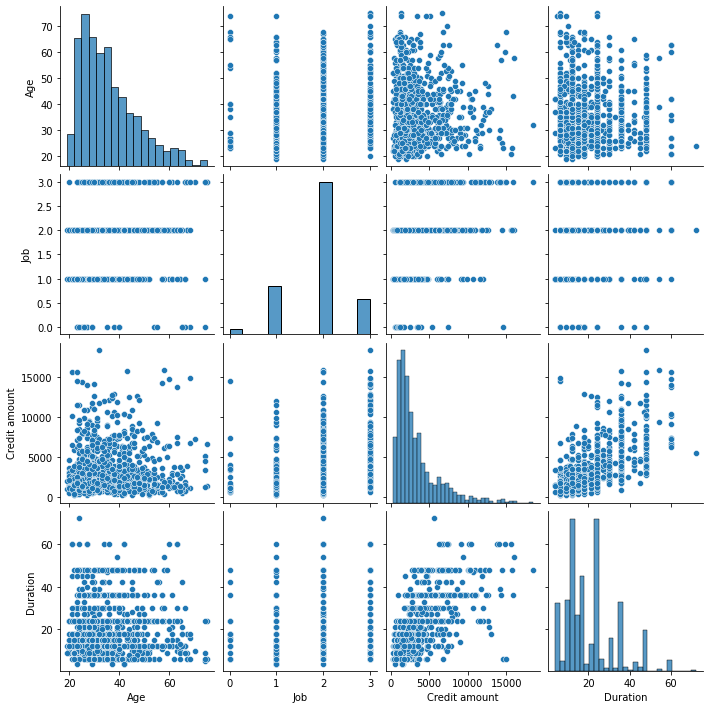

In [ ]:
import seaborn as sns

sns.pairplot(df_model)


Métricas de avaliação de treino:
[[ 57 183]
 [ 51 509]]


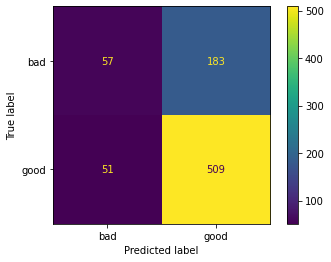

              precision    recall  f1-score   support

         bad       0.53      0.24      0.33       240
        good       0.74      0.91      0.81       560

    accuracy                           0.71       800
   macro avg       0.63      0.57      0.57       800
weighted avg       0.67      0.71      0.67       800


Métricas de avaliação de teste:
[[ 17  43]
 [ 15 125]]


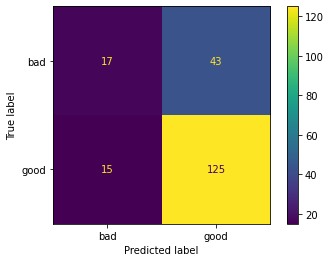

              precision    recall  f1-score   support

         bad       0.53      0.28      0.37        60
        good       0.74      0.89      0.81       140

    accuracy                           0.71       200
   macro avg       0.64      0.59      0.59       200
weighted avg       0.68      0.71      0.68       200



In [ ]:
# ============================================

gnb = GaussianNB().fit(X_train, y_train)

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = gnb.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = gnb.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

Agora, com o multinomial NB...


Métricas de avaliação de treino:
[[100 140]
 [154 406]]


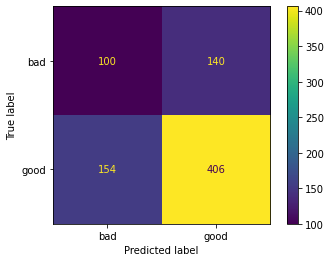

              precision    recall  f1-score   support

         bad       0.39      0.42      0.40       240
        good       0.74      0.72      0.73       560

    accuracy                           0.63       800
   macro avg       0.57      0.57      0.57       800
weighted avg       0.64      0.63      0.64       800


Métricas de avaliação de teste:
[[26 34]
 [45 95]]


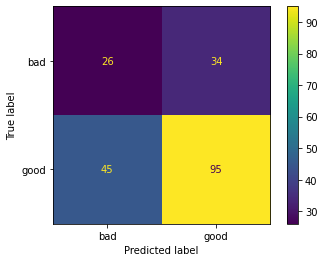

              precision    recall  f1-score   support

         bad       0.37      0.43      0.40        60
        good       0.74      0.68      0.71       140

    accuracy                           0.60       200
   macro avg       0.55      0.56      0.55       200
weighted avg       0.63      0.60      0.61       200



In [ ]:
# ============================================

mnb = MultinomialNB().fit(X_train, y_train)

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = mnb.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = mnb.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

Já com o Bernoulli...

In [ ]:
from sklearn.naive_bayes import BernoulliNB


Métricas de avaliação de treino:
[[  0 240]
 [  0 560]]


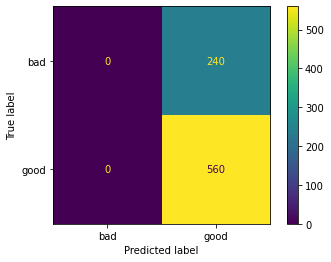

C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         bad       0.00      0.00      0.00       240
        good       0.70      1.00      0.82       560

    accuracy                           0.70       800
   macro avg       0.35      0.50      0.41       800
weighted avg       0.49      0.70      0.58       800


Métricas de avaliação de teste:
[[  0  60]
 [  0 140]]


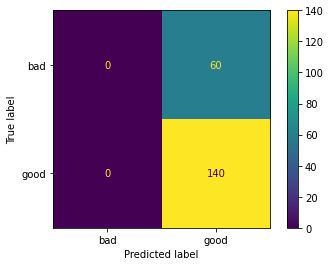

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00        60
        good       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200



C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ============================================

bnb = BernoulliNB().fit(X_train, y_train)

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = bnb.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = bnb.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

____
____
____